
### Initial Comments

First of all thankyou to G-Research and Cambridge Spark for hosting this competition and to the Kaggle staff for making everything run relatively smoothly. I found it so interesting and more open ended than other comps I've competed in, in my short Kaggler career.

It goes without saying that while I'm in 1st Place now there is no guarantee it will stay that way in the next 6 weeks, but I'm confident I'll be there or thereabouts. Hopefully you find this solution useful regardless of the final outcome.

Elephant in the room - there has been a lot of concern about the validity of the final LB results and requests to release the final test data after the competition ends so that competitors can validate their final scores. I think this would be a good idea and should put any concerns to bed. If it's possible & not too much effort for Kaggle to accomodate the request please consider it. However, as far as im concerned my current score seems reasonable based on all the scores I achieved in testing. I have no reason to believe any of the LB scores are incorrect until there is evidence to the contrary.

**I would encourage those who feel their score is unexpected share their solutions as the Kaggle community might be able to debug any issues/misunderstandings.**

It is obviously difficult to accurately predict crypto prices, but it's possible to find *some* signal - hopefully this notebook will shed some light on how I got mine.

*Disclaimers*
- *this was not my exact final submission but very similar*
- *I have removed the dataset containing my pretrained models and scalers - so some commands will error*

### Summary

- 17 features with lagged and timestamp averages for all models.
- Ensembles of LGBM and Keras NN models.
- Target Engineering and prediction switching.
- Some training on extra cryptos outside competition scope.

Test Scores (no lookahead bias):
- 0.0565 best score on original testing period (Jun 13 2021 - Sep 21 2021)
- 0.0475 best score on supplemental_train.csv update. (Sep 21 2021 - Jan 24 2022)
- 0.0465 best single model score (Jun 13 2021 - Sep 21 2021)

### External Data
I downloaded free public data from multiple exchange apis (Binance, FTX, Coinbase, Kucoin... etc.) to see if this extra data would improve my models. Some of my final models were trained on extra data. Specifically, using some currencies not included in the competition (e.g. XRP, ZEC...) from Binance seemed to provide a consistent small improvement over multiple timeframes.

### Feature Engineering
I settled on a group of 17 features for all models. There are 8 lagged features - **a simple mixture of EMA's, historical returns and historical volatility over various lookback periods** - and these features were averaged across timestamps to produce 8 more. Asset_ID was also included. It was tricky to find a group that performed the best consistently across different time periods, adding and removing features from this set seemed to reduce performance. Im sure this isnt the optimal feature set, but this group seemed to work well enough.

It was also important to perform some kind on binning on the features, especially for training the LGBM model. The commonly used reduce_mem_usage function and some rounding functions seemed to provide a suitable amount of bins. I found binning to 500-1000 unique values worked well for any given continuous feature.

### Target Engineering
I think a crucial part of this competition was manipulating the target. Thanks to the work of **@alexfir** and other kagglers [we found out how the target was being calculated](https://www.kaggle.com/alexfir/recreating-target).
I thought it would be useful to split the target into two components:
- The forward 15 minute return of an asset
- The beta component, where we calculate the mean of forward 15 minute returns for all assets and incorporate past 15 minute returns for the previous 3750 timestamps

As **@gengdaiziwang** illustrates [in his helpful notebook](https://www.kaggle.com/gengdaiziwang/are-we-training-models-on-an-inaccurate-target), we can see that in the case where an observation is missing for a given asset, the beta component is automatically set to 0.

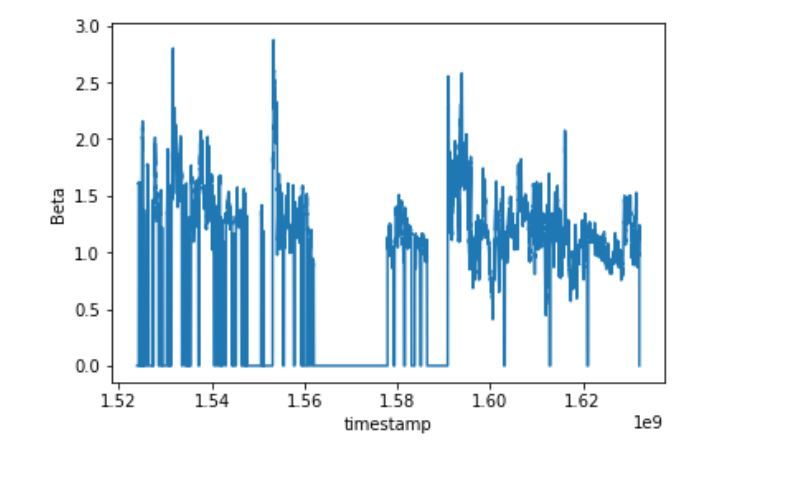

But this makes it a completely different target! A model trained on the target given as standard will have to deal with training on a target that randomly switches between a 15 minute forward return for one asset vs what is essentially a 15 minute forward return *relative to the other assets* - very different things.

The approach I took was to create recreate two targets to represent these two different cases. Then I could train separate models on these recreated targets which would learn the two cases much more effectively.
[See an implementation of this target engineering](https://www.kaggle.com/tomforbes/target-engineering).

Now, having two models trained on different targets, I can alter my predictions to match the target produced by the api. The api provides all the information i need to figure out whether the beta component will be == 0 because if an asset is missing from an iteration i know that for the next 3750 iterations the beta component == 0 for this asset. **Therefore my next 3750 predictions will come from a model that was training on a target constructued without a beta component.**

This target engineering and dual model method added roughly 0.01 to my score on the original test period, although this did vary quite significantly for other testing periods.

To summarise as simply as possible:

- TargetZero = A target based on 15 minute Forward Return only
- TargetBeta = TargetZero + Beta Component
- ModelZero = Model(s) trained on TargetZero
- ModelBeta = Model(s) trained on TargetBeta

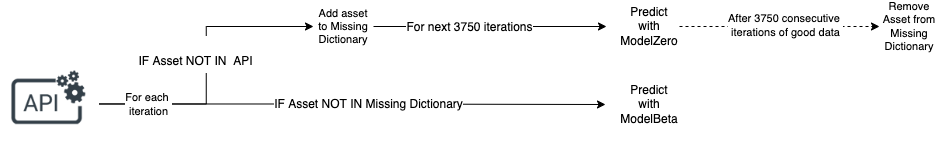

### Models

I found LightGBM worked well and was easy to experiment with, i used the weighted correlation evaluation metric and fairly out of the box hyperparameters, tuning didnt seem to add much and wasn't consistent across time periods.

I also used a Keras NN heavily influenced by **@lucasmorin's**
[excellent notebook](http://https://www.kaggle.com/lucasmorin/online-fe-nn-loss-shap). This just worked really well for me out of the box and i couldnt find many ways to improve the architecture or hyperparameters.

Ensembling these two models worked well and added an extra 0.005 to my score (roughly) although the improvement varies in different market regimes. I also experimented with ensembles using catboost and XGboost but the predictions from most gradient boosting models were too highly correlated to provide much ensembling benefit. I found the diversity in predictions between NN and GB were a good match.

I used a fairly simple CV method for training and testing. My folds were based on timestamp values similar to the below:
- Training Fold 0: 1514764860 - 1570000000 
- Training Fold 1: 1514764860 - 1580000000 
- Training Fold 2: 1514764860 - 1590000000 
- Training Fold 3: 1514764860 - 1600000000 
- Training Fold 4: 1514764860 - 1610000000
- Validation Fold 0: 1570000000 - 1580000000
- Validation Fold 1: 1580000000 - 1590000000 
- Validation Fold 2: 1590000000 - 1600000000 
- Validation Fold 3: 1600000000 - 1610000000 
- Validation Fold 4: 1610000000 - 1620000000 
- Test Fold A: 1615000000 - 1623542400
- Test Fold B (Supplemental Train Update): 1623542400 - 1643000000

Since this public lb was useless in this competition, it was essential to construct a robust CV framework to have a reliable benchmark for making improvements to models. It was also important to have test folds in several different market regimes to avoid overfitting to one period.

**My best single model was a NN trained on fold 0 data only (surprisingly).**

I was fairly selective on picking models to include in the final submission as some folds just trained much better than others and had more consistent outperformance on unseen data.

### Submission

This is almost the exact notebook I submitted for my final predictions. I used lists to store historical data for feature calculations and did most calculations using numpy or lists, avoiding pandas at all costs.

The submission completes in roughly 7 hours.


### What didnt work
- Layering extra data from different exchanges for the same asset. E.g training on BTC data from Binance + Coinbase + FTX + G-Research version. Didnt harm but didnt improve models significantly either.
- Framing as a classification problem - poor results
- Hyperparameter tuning LGBM
- PCA features
- Using all 14 assets features per row / predicting on 14 targets.
- Meta modelling GB and NN predictions

### With more time id try
- Extra Feature engineering
- Pytorch implementation of keras NN for ensembling
- LSTM
- Other model architectures



In [ ]:
# importing and installing tensorflow version 2.7.0 offline
! ls ../input/tensor270/gresearch2/gresearch

In [ ]:
# importing and installing tensorflow version 2.7.0 offline
!mkdir -p /tmp/pip/cache/
!cp ../input/tensor270/gresearch2/gresearch/Keras_Preprocessing-1.1.2-py2.py3-none-any.whl /tmp/pip/cache/
!cp ../input/tensor270/gresearch2/gresearch/Markdown-3.3.6-py3-none-any.whl /tmp/pip/cache/
!cp ../input/tensor270/gresearch2/gresearch/Werkzeug-2.0.2-py3-none-any.whl /tmp/pip/cache/
!cp ../input/tensor270/gresearch2/gresearch/absl_py-1.0.0-py3-none-any.whl /tmp/pip/cache/
!cp ../input/tensor270/gresearch2/gresearch/astunparse-1.6.3-py2.py3-none-any.whl /tmp/pip/cache/
!cp ../input/tensor270/gresearch2/gresearch/cached_property-1.5.2-py2.py3-none-any.whl /tmp/pip/cache/
!cp ../input/tensor270/gresearch2/gresearch/cachetools-4.2.4-py3-none-any.whl /tmp/pip/cache/
!cp ../input/tensor270/gresearch2/gresearch/certifi-2021.10.8-py2.py3-none-any.whl /tmp/pip/cache/
!cp ../input/tensor270/gresearch2/gresearch/charset_normalizer-2.0.10-py3-none-any.whl /tmp/pip/cache/
!cp ../input/tensor270/gresearch2/gresearch/flatbuffers-2.0-py2.py3-none-any.whl /tmp/pip/cache/
!cp ../input/tensor270/gresearch2/gresearch/gast-0.4.0-py3-none-any.whl /tmp/pip/cache/
!cp ../input/tensor270/gresearch2/gresearch/google_auth-2.3.3-py2.py3-none-any.whl /tmp/pip/cache/
!cp ../input/tensor270/gresearch2/gresearch/google_auth_oauthlib-0.4.6-py2.py3-none-any.whl /tmp/pip/cache/
!cp ../input/tensor270/gresearch2/gresearch/google_pasta-0.2.0-py3-none-any.whl /tmp/pip/cache/
!cp ../input/tensor270/gresearch2/gresearch/grpcio-1.43.0-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl /tmp/pip/cache/
!cp ../input/tensor270/gresearch2/gresearch/h5py-3.6.0-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl /tmp/pip/cache/
!cp ../input/tensor270/gresearch2/gresearch/idna-3.3-py3-none-any.whl /tmp/pip/cache/
!cp ../input/tensor270/gresearch2/gresearch/importlib_metadata-4.10.1-py3-none-any.whl /tmp/pip/cache/
!cp ../input/tensor270/gresearch2/gresearch/keras-2.7.0-py2.py3-none-any.whl /tmp/pip/cache/
!cp ../input/tensor270/gresearch2/gresearch/libclang-12.0.0-2-py2.py3-none-manylinux1_x86_64.whl /tmp/pip/cache/
!cp ../input/tensor270/gresearch2/gresearch/numpy-1.21.5-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl /tmp/pip/cache/
!cp ../input/tensor270/gresearch2/gresearch/oauthlib-3.1.1-py2.py3-none-any.whl /tmp/pip/cache/
!cp ../input/tensor270/gresearch2/gresearch/opt_einsum-3.3.0-py3-none-any.whl /tmp/pip/cache/
!cp ../input/tensor270/gresearch2/gresearch/protobuf-3.19.3-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl /tmp/pip/cache/
!cp ../input/tensor270/gresearch2/gresearch/pyasn1-0.4.8-py2.py3-none-any.whl /tmp/pip/cache/
!cp ../input/tensor270/gresearch2/gresearch/pyasn1_modules-0.2.8-py2.py3-none-any.whl /tmp/pip/cache/
!cp ../input/tensor270/gresearch2/gresearch/requests-2.27.1-py2.py3-none-any.whl /tmp/pip/cache/
!cp ../input/tensor270/gresearch2/gresearch/requests_oauthlib-1.3.0-py2.py3-none-any.whl /tmp/pip/cache/
!cp ../input/tensor270/gresearch2/gresearch/rsa-4.8-py3-none-any.whl /tmp/pip/cache/
!cp ../input/tensor270/gresearch2/gresearch/setuptools-60.5.0-py3-none-any.whl /tmp/pip/cache/
!cp ../input/tensor270/gresearch2/gresearch/six-1.16.0-py2.py3-none-any.whl /tmp/pip/cache/
!cp ../input/tensor270/gresearch2/gresearch/tensorboard-2.7.0-py3-none-any.whl /tmp/pip/cache/
!cp ../input/tensor270/gresearch2/gresearch/tensorboard_data_server-0.6.1-py3-none-manylinux2010_x86_64.whl /tmp/pip/cache/
!cp ../input/tensor270/gresearch2/gresearch/tensorboard_plugin_wit-1.8.1-py3-none-any.whl /tmp/pip/cache/
!cp ../input/tensor270/gresearch2/gresearch/tensorflow-2.7.0-cp37-cp37m-manylinux2010_x86_64.whl /tmp/pip/cache/
!cp ../input/tensor270/gresearch2/gresearch/tensorflow_estimator-2.7.0-py2.py3-none-any.whl /tmp/pip/cache/
!cp ../input/tensor270/gresearch2/gresearch/tensorboard_data_server-0.6.1-py3-none-manylinux2010_x86_64.whl /tmp/pip/cache/
!cp ../input/tensor270/gresearch2/gresearch/tensorboard_plugin_wit-1.8.1-py3-none-any.whl /tmp/pip/cache/
!cp ../input/tensor270/gresearch2/gresearch/tensorflow-2.7.0-cp37-cp37m-manylinux2010_x86_64.whl /tmp/pip/cache/
!cp ../input/tensor270/gresearch2/gresearch/tensorflow_estimator-2.7.0-py2.py3-none-any.whl /tmp/pip/cache/
!cp ../input/tensor270/gresearch2/gresearch/tensorflow_io_gcs_filesystem-0.23.1-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl /tmp/pip/cache/
!cp ../input/tensor270/gresearch2/gresearch/termcolor-1.1.0 /tmp/pip/cache/termcolor-1.1.0.tar.gz
!cp ../input/tensor270/gresearch2/gresearch/typing_extensions-4.0.1-py3-none-any.whl /tmp/pip/cache/
!cp ../input/tensor270/gresearch2/gresearch/urllib3-1.26.8-py2.py3-none-any.whl /tmp/pip/cache/
!cp ../input/tensor270/gresearch2/gresearch/wheel-0.37.1-py2.py3-none-any.whl /tmp/pip/cache/
!cp ../input/tensor270/gresearch2/gresearch/wrapt-1.13.3-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl /tmp/pip/cache/
!cp ../input/tensor270/gresearch2/gresearch/zipp-3.7.0-py3-none-any.whl /tmp/pip/cache/



In [ ]:
# importing and installing tensorflow version 2.7.0 offline
!pip install --no-index --find-links /tmp/pip/cache/ tensorflow

In [ ]:
import os
import random
import pandas as pd
import numpy as np
import lightgbm as lgb
import gresearch_crypto
import time
import datetime
import gc
import joblib

from tensorflow import keras
from keras import backend as K
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

TRAIN_CSV = '/kaggle/input/g-research-crypto-forecasting/train.csv'
ASSET_DETAILS_CSV = '/kaggle/input/g-research-crypto-forecasting/asset_details.csv'
tf.__version__

In [ ]:
def m(x, w):
    """Weighted Mean"""
    return np.sum(x * w) / np.sum(w)

def cov(x, y, w):
    """Weighted Covariance"""
    return np.sum(w * (x - m(x, w)) * (y - m(y, w))) / np.sum(w)

def corr(x, y, w):
    """Weighted Correlation"""
    return cov(x, y, w) / np.sqrt(cov(x, x, w) * cov(y, y, w))


def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
#         else:
#             df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


In [ ]:
class getFeatures():
    """
    Class for creating and storing features.
    """
    def __init__(self,windows=[]):
        self.max_length=max(windows)
        self.dataframes=[]
    def compute(self,current):
        """
        Function to append current close price to dataframes variable
        and returns list of features.
        """
        if len(self.dataframes)>2010:
            self.dataframes = self.dataframes[-2010:]
        self.dataframes.append(float(current['Close']))
           
        return30 = current['Close']/np.array(self.dataframes)[max([-1*len(self.dataframes),-30])]
        return120 = current['Close']/np.array(self.dataframes)[max([-1*len(self.dataframes),-120])]
        
        volatility15 = np.std(np.array(self.dataframes)[max([-1*len(self.dataframes),-15]):])/np.std(np.array(self.dataframes)[max([-1*len(self.dataframes),-500]):])
        volatility200 = np.std(np.array(self.dataframes)[max([-1*len(self.dataframes),-200]):])/np.std(np.array(self.dataframes)[max([-1*len(self.dataframes),-2000]):])
        
        #ema7 =  pd.Series(self.dataframes[max([-1*len(self.dataframes),-7]):]).ewm(span=7, min_periods=1, adjust=False).mean().iloc[-1]/current['Close'] # 15min window average
        ema21 =  pd.Series(self.dataframes[max([-1*len(self.dataframes),-21]):]).ewm(span=21, min_periods=5, adjust=False).mean().iloc[-1]/current['Close'] # 15min window average
        ema35 =  pd.Series(self.dataframes[max([-1*len(self.dataframes),-35]):]).ewm(span=35, min_periods=10, adjust=False).mean().iloc[-1]/current['Close'] # 15min window average
        #ema55 =  pd.Series(self.dataframes[max([-1*len(self.dataframes),-55]):]).ewm(span=55, min_periods=15, adjust=False).mean().iloc[-1]/current['Close'] # 15min window average
        ema80 =  pd.Series(self.dataframes[max([-1*len(self.dataframes),-80]):]).ewm(span=80, min_periods=20, adjust=False).mean().iloc[-1]/current['Close'] # 15min window average
        #ema110 =  pd.Series(self.dataframes[max([-1*len(self.dataframes),-110]):]).ewm(span=110, min_periods=25, adjust=False).mean().iloc[-1]/current['Close'] # 15min window average
        ema250 =  pd.Series(self.dataframes[max([-1*len(self.dataframes),-250]):]).ewm(span=250, min_periods=30, adjust=False).mean().iloc[-1]/current['Close'] # 15min window average
        
        if return30>2:
            return30 = 2
        if return30<0.5:
            return30 = 0.5
            
        if return120>2:
            return120 = 2
        if return120<0.5:
            return120 = 0.5
            
        if volatility15>5:
            volatility15 = 5
        if volatility15<0:
            volatility15 = 0
            
        if volatility200>5:
            volatility200 = 5
        if volatility200<0:
            volatility200 = 0
            
        if ema21>2:
            ema21 = 2
        if ema21<0.5:
            ema21 = 0.5
            
        if ema35>2:
            ema35 = 2
        if ema35<0.5:
            ema35 = 0.5
            
        if ema80>2:
            ema80 = 2
        if ema80<0.5:
            ema80 = 0.5
            
        if ema250>2:
            ema250 = 2
        if ema250<0.5:
            ema250 = 0.5
        
        
        if str(return30) in ['nan','inf','-inf']:
            return30 = 1
        if str(return120) in ['nan','inf','-inf']:
            return120 = 1
        if str(volatility15) in ['nan','inf','-inf']:
            volatility15 = 0.2
        if str(volatility200) in ['nan','inf','-inf']:
            volatility200 = 0.2
        if str(ema21) in ['nan','inf','-inf']:
            ema21 = 1
        if str(ema35) in ['nan','inf','-inf']:
            ema35 = 1
        if str(ema80) in ['nan','inf','-inf']:
            ema80 = 1
        if str(ema250) in ['nan','inf','-inf']:
            ema250 = 1
        
        if len(self.dataframes)<5:
            return [1, 1, 0.2, 0.2, 1, 1, 1, 1]
        else:
            return [return30, return120, volatility15, volatility200, ema21, ema35, ema80, ema250]
    

In [ ]:
feats=[getFeatures([2010]) for _ in range(14)]

In [ ]:
# lgb models trained on zerobeta target

modelzero0a = joblib.load('../input/gresmodels/ema14_other_feval_fullzero/lgb_model_val_beta0_0.pkl')
modelzero1a = joblib.load('../input/gresmodels/ema14_other_feval_fullzero/lgb_model_val_beta1_0.pkl')
modelzero2a = joblib.load('../input/gresmodels/ema14_other_feval_fullzero/lgb_model_val_beta2_0.pkl')

# lgb models trained on fullbeta target

modelfull2b = joblib.load('../input/gresmodels/ema014otherfevalbeta14fold/lgb_model_val_beta2_0.pkl')
modelfull3b = joblib.load('../input/gresmodels/ema014otherfevalbeta14fold/lgb_model_val_beta3_0.pkl')
modelfull5b = joblib.load('../input/gresmodels/ema014otherfevalbeta14fold/lgb_model_val_beta5_0.pkl')
modelfull8b = joblib.load('../input/gresmodels/ema014otherfevalbeta14fold/lgb_model_val_beta8_0.pkl')
modelfull10b = joblib.load('../input/gresmodels/ema014otherfevalbeta14fold/lgb_model_val_beta10_0.pkl')
modelfull11b = joblib.load('../input/gresmodels/ema014otherfevalbeta14fold/lgb_model_val_beta11_0.pkl')
modelfull12b = joblib.load('../input/gresmodels/ema014otherfevalbeta14fold/lgb_model_val_beta12_0.pkl')
modelfull13b = joblib.load('../input/gresmodels/ema014otherfevalbeta14fold/lgb_model_val_beta13_0.pkl')



In [ ]:
# various minmax scalers for transforming test data to appropriate distribution
scaler1 = joblib.load('../input/gresmodels/scalers/scaler1.save')
scaler4 = joblib.load('../input/gresmodels/scalers/scaler4.save')
scaler01 = joblib.load('../input/gresmodels/scalers/scaler01.save')
scaler02 = joblib.load('../input/gresmodels/scalers/scaler02.save')
scaler03 = joblib.load('../input/gresmodels/scalers/scaler03.save')
scaler01best = joblib.load('../input/gresmodels/scalers/scaler01best.save')
scaler02best = joblib.load('../input/gresmodels/scalers/scaler02best.save')
scalerzero = joblib.load('../input/gresmodels/scalers/scalerzero.save')

In [ ]:
# loading keras neural net models
model1 = keras.models.load_model('../input/gresmodels/emadnnbetamodel0seed0/emadnnbetamodel0seed0', compile=False)
model4 = keras.models.load_model('../input/gresmodels/emadnnfeval014extrafevalmodel4seed0lr1', compile=False)
model01 = keras.models.load_model('../input/gresmodels/emadnnfeval0onlybetafold1seed0lr1', compile=False)
model02 = keras.models.load_model('../input/gresmodels/emadnnfeval0onlybetafold2seed0lr1', compile=False)
model03 = keras.models.load_model('../input/gresmodels/emadnnfeval0onlybetafold3seed0lr1', compile=False)
model01best = keras.models.load_model('../input/gresmodels/emadnnfeval0onlybetafold1seed0lr1best', compile=False)
model02best = keras.models.load_model('../input/gresmodels/emadnnfeval0onlybetafold2seed0lr1best', compile=False)
modeldnnzero = keras.models.load_model('../input/gresmodels/emadnnfeval0onlyzerofold0seed0', compile=False)


In [ ]:
# defining mean and stdev variables for all models
# we use these to normalise the predictions from the LGBM and DNN models so they can be ensembled

dnnmean1 = 0.016834533105211127
dnnstd1 = 5.367454277045551 
dnnmean4 = -0.16693439553133801
dnnstd4 = 6.459708512850307 
dnnmean01 = 0.055314195869729785
dnnstd01 = 6.723390661480986 
dnnmean02 = 0.10034501108790424
dnnstd02 = 7.438331336036615 

dnnmean03 = 0.019139631916902544
dnnstd03 = 5.675169602420376 
dnnmean01best = 0.09889716583318675
dnnstd01best = 6.784986628806578 
dnnmean02best = 0.015836443924659535
dnnstd02best = 7.490301098140777 
lgbmmean1 = -6.812755955898616e-06
lgbmstd1 = 0.0006158765594927516 

lgbmmean2 = -1.0658401603886789e-05 
lgbmstd2 = 0.0006463366961800999  
lgbmmean3 = -1.2944577273296175e-05
lgbmstd3 = 0.0005934272368661652 
xgbmmean = 0.002491480874423726
xgbmstd = 0.0010478100911640877  
lgbmzeromean = 1.814303436247774e-05
lgbmzerostd = 0.0010088461763049226 
dnnzeromean = 0.02286166896039839
dnnzerostd = 0.8958637238915896


In [ ]:
# missingdict will store assets that have previously missed a timestamp
# this is important because if an asset has been missing from a timestamp in the last 3750 iterations
# then we know that the beta component of the target will == 0.
missingdict = {}

try:
    # create a running start for missingdict relative to the supplemental train period
    train = pd.read_csv('../input/g-research-crypto-forecasting/supplemental_train.csv')
    train = train[train['timestamp']<1643760000]
    train = train[train['timestamp']>1643260000]
    timestamps = sorted(train['timestamp'].unique())
    train = train[['timestamp','Asset_ID','Close','Target']]

    
    for z, timestamp in enumerate(timestamps):
        df_test = train[train['timestamp']==timestamp] 
        ids = list(df_test['Asset_ID'].unique())

        missing = [i for i in range(14) if i not in ids]
        missing = list(set(missing))

        if len(missing)>0:
            for i in missing:
                missingdict[i] = 0

        keys = list(missingdict.keys())
        for i in keys:
            missingdict[i] = missingdict[i]+1
            if missingdict[i] == 3750:
                del missingdict[i]
        
        # calculate features for running start
        for j, row in df_test.iterrows():
            asset_id = int(row['Asset_ID'])
            feat=feats[asset_id]
            row_features1=feat.compute(row)

        if z%100==0:
            print(missingdict)
except:
    missingdict = {}


In [ ]:
start = time.time()
env = gresearch_crypto.make_env()
iter_test = env.iter_test()
for i, (df_test, df_pred) in enumerate(iter_test):
    
    
    ids = list(df_test['Asset_ID'].unique())
    
    # create a list of missing asset_ids
    missing = [i for i in range(14) if i not in ids]
    missing = list(set(missing))
    
    # for each missing asset, add to the missing dictionary
    if len(missing)>0:
        for i in missing:
            missingdict[i] = 0
    
    # we increment the value assigned to each asset per iteration
    # we remove the asset from the missing dictionary after 3750 iterations
    # this is because after valid 3750 iterations beta is being calculated again
    keys = list(missingdict.keys())
    for i in keys:
        missingdict[i] = missingdict[i]+1
        if missingdict[i] == 3750:
            del missingdict[i]
    
    # compute features for each asset
    dict_ = {0:[],1:[], 2:[],3:[], 4:[], 5:[],6:[], 7:[],8:[],9:[],10:[],11:[],12:[],13:[]}
    arravg = []
    for j , row in df_test.iterrows():
        asset_id = int(row['Asset_ID'])
        row_id = int(row['row_id'])
        feat=feats[asset_id]
        row_features1=feat.compute(row)
        if arravg==[]:
            arravg = np.array([row_features1])
        else:
            arravg = np.append(arravg, [row_features1], axis=0)
        row_features1 = [row_id, asset_id] + row_features1
        
        dict_[asset_id] = row_features1 
    
    # calculate timestamp means for all features
    means = list(arravg.mean(axis=0))
    rows,fullbeta,zerobeta,rowidsbeta,rowidszero = [], [], [], [], []
    for i in ids:
        rowid = dict_[i][0]
        rowsbeta = dict_[i][1:]
        rowsbeta = rowsbeta + means
        # add asset features to zerobeta list or fullbeta list depending on whether asset is in missingdict
        if i in missingdict.keys():
            zerobeta.append(rowsbeta)
            rowidszero.append(rowid)
        else:
            fullbeta.append(rowsbeta)
            rowidsbeta.append(rowid)
    
    # create normalised predictions for dnn & lgbm models
    
    dnnrowsbeta = scaler1.transform(np.array(fullbeta))
    dnn_pred = model1.predict_on_batch(np.array(dnnrowsbeta)).reshape(1,-1)[0]
    dnn_pred1 = (dnn_pred-dnnmean1)/dnnstd1
    
    dnnrowsbeta = scaler4.transform(np.array(fullbeta))
    dnn_pred = model4.predict_on_batch(np.array(dnnrowsbeta)).reshape(1,-1)[0]
    dnn_pred4 = (dnn_pred-dnnmean4)/dnnstd4
    
    dnnrowsbeta = scaler01.transform(np.array(fullbeta))
    dnn_pred = model01.predict_on_batch(np.array(dnnrowsbeta)).reshape(1,-1)[0]
    dnn_pred01 = (dnn_pred-dnnmean01)/dnnstd01
    
    dnnrowsbeta = scaler02.transform(np.array(fullbeta))
    dnn_pred = model02.predict_on_batch(np.array(dnnrowsbeta)).reshape(1,-1)[0]
    dnn_pred02 = (dnn_pred-dnnmean02)/dnnstd02
    
    dnnrowsbeta = scaler03.transform(np.array(fullbeta))
    dnn_pred = model03.predict_on_batch(np.array(dnnrowsbeta)).reshape(1,-1)[0]
    dnn_pred03 = (dnn_pred-dnnmean03)/dnnstd03
    
    dnnrowsbeta = scaler01best.transform(np.array(fullbeta))
    dnn_pred = model01best.predict_on_batch(np.array(dnnrowsbeta)).reshape(1,-1)[0]
    dnn_pred01best = (dnn_pred-dnnmean01best)/dnnstd01best
    
    dnnrowsbeta = scaler02best.transform(np.array(fullbeta))
    dnn_pred = model02best.predict_on_batch(np.array(dnnrowsbeta)).reshape(1,-1)[0]
    dnn_pred02best = (dnn_pred-dnnmean02best)/dnnstd02best
    
    dnn_pred = (dnn_pred1 + dnn_pred4 + dnn_pred01 + dnn_pred02 
                + dnn_pred03 + dnn_pred01best + dnn_pred02best)/7
    
    lgbm_pred2b = modelfull2b.predict(np.array(fullbeta))
    lgbm_pred3b = modelfull3b.predict(np.array(fullbeta))
    lgbm_pred5b = modelfull5b.predict(np.array(fullbeta))
    lgbm_pred8b = modelfull8b.predict(np.array(fullbeta))
    lgbm_pred10b = modelfull10b.predict(np.array(fullbeta))
    lgbm_pred11b = modelfull11b.predict(np.array(fullbeta))
    lgbm_pred12b = modelfull12b.predict(np.array(fullbeta))
    lgbm_pred13b = modelfull13b.predict(np.array(fullbeta))
    
    lgbm_predbeta = (lgbm_pred2b + lgbm_pred3b  + lgbm_pred5b  + lgbm_pred8b  
              + lgbm_pred10b + lgbm_pred11b + lgbm_pred12b + lgbm_pred13b)/8

    lgbm_pred = (lgbm_predbeta-lgbmmean1)/lgbmstd1

    # ensemble lgbm and dnn predictions and write to df_pred
    for ind, rowid in enumerate(rowidsbeta):
        df_pred.loc[df_pred['row_id'] == int(rowid), 'Target'] = lgbm_pred[ind]*0.35 + dnn_pred[ind]*0.65
    
    # predicitions for assets in missingdict using models trained on zerobeta targets
    if zerobeta == []:
        pass
    else:
        dnnrowszero = scalerzero.transform(np.array(zerobeta))

        dnn_predzero = modeldnnzero.predict_on_batch(np.array(dnnrowszero)).reshape(1,-1)[0]
        dnn_predzero = (dnn_predzero-dnnzeromean)/dnnzerostd
        
        lgbm_pred0a = modelzero0a.predict(np.array(zerobeta))
        lgbm_pred1a = modelzero1a.predict(np.array(zerobeta))
        lgbm_pred2a = modelzero2a.predict(np.array(zerobeta))

        lgbm_predzero = (lgbm_pred0a  + lgbm_pred1a  + lgbm_pred2a)/3
        lgbm_predzero = (lgbm_predzero - lgbmzeromean) / lgbmzerostd
        
        for ind, rowid in enumerate(rowidszero):
            df_pred.loc[df_pred['row_id'] == int(rowid), 'Target'] = lgbm_predzero[ind]*0.5 + dnn_predzero[ind]*0.5
    
    # Send submissions
    env.predict(df_pred)
stop = time.time()
print(stop-start)
